# Logistic Regression with a Neural Network mindset

Welcome! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images.

y = [1], it's a 'cat' picture.
(209, 64, 64, 3)


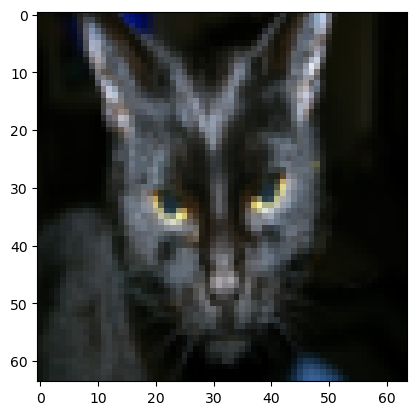

In [3]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")


print(train_set_x_orig.shape)


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

**1. Exercise:** Find and print the values for:
- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)

In [4]:
### START CODE HERE ###
m_train, num_px, _, _ = train_set_x_orig.shape
m_test, _,_,_ = test_set_x_orig.shape 

print(f"m_train: {m_train}")
print(f"m_test: {m_test}")
print(f"num_px: {num_px}")


### END CODE HERE ###

m_train: 209
m_test: 50
num_px: 64


**Expected Output for m_train, m_test and num_px**:
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td>
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td>
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td>
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**2. Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [5]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T 
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**:

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td>
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td>
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td>
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td>
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td>
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !-->

Let's standardize our dataset.

In [6]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ##

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**3. Exercise**: Implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [7]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###

    return s

In [8]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**:

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td>
  </tr>
</table>

### 4.2 - Initializing parameters

**4. Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [9]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**:


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**5. Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

In [11]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X)+b)                                     # compute activation
    cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost

    ### END CODE HERE ###

    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = np.dot(X,(A - Y).T) / m
    db = np.sum(A - Y) / m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [12]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**6. Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [13]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        ### START CODE HERE ###
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###

        # update rule for w and b
        ### START CODE HERE ###
        dw = grads.get("dw")
        db =  grads.get("db")
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067654


**Expected Output**:

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
   <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>

   <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

**7. Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this).

In [15]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ###
    A = sigmoid(np.dot(w.T,X)+b)

    ### END CODE HERE ###

    # Convert probabilities to actual predictions
    ### START CODE HERE ###
    Y_prediction = (A>0.5)*1
    ### END CODE HERE ###



    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [16]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


**Expected Output**:

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**8. Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [17]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###

    # initialize parameters with zeros (≈ 1 line of code)
    dim = X_train.shape[0]
    w, b = initialize_with_zeros(dim)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

Run the following cell to train your model.

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**:

<table style="width:40%">
    <tr>
        <td>
            **Cost after iteration 0 **  
        </td>
        <td>
            0.693147
        </td>
    </tr>
    <tr>
        <td> <center> ... </center> </td>
        <td> <center>... </center> </td>
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td>
        <td> 99.04306220095694 % </td>
    </tr>
    <tr>
        <td> **Test Accuracy** </td>
        <td> 70.0 % </td>
    </tr>
</table>




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier.

y = 1, you predicted that it is a "cat" picture.


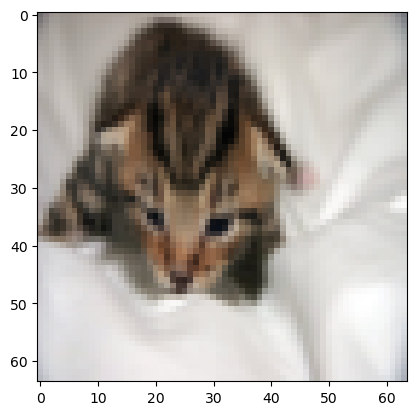

In [19]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

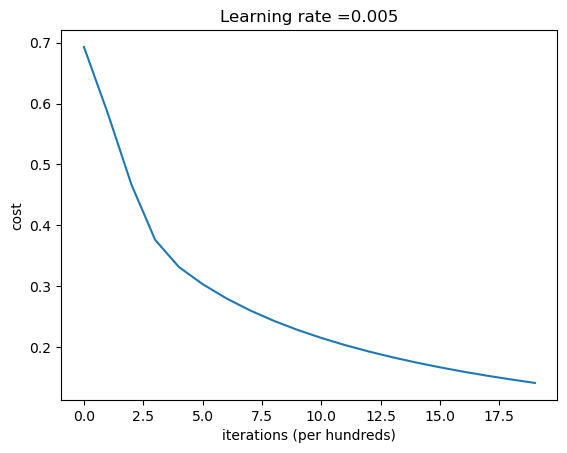

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.


## Aditional Exercise ( 25 points)
This is an all-or-nothing exercise. If you fail fulfilling one of the following items, your solution will be invalidated:
(5 points) Create a database of at least 200 images, test your classifier and report your result. Your database will have the following characteristics:

* 100 images of the positive class; i.e., images with cats.
* 100 images of the negative class; i.e., images without dogs
* Please report and discuss:
    * Description of the used dataset, e.g., number of training and testing samples, kind of data, problem, etc.
    * Train and test accuracy.
    * Play with the learning rate and the number of iterations.
    * Try different initialization methods and compare the results.
    * Test other pre-processings (center the data, or divide each row by its standard deviation)


We will be using the set labeled as "train" from https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification?select=train which contains 279 images of cats and 278 images from dogs. We will first process them to reduce their pixel resolution to the same as the ones we used in the training (64 pixels x 64 pixels) and then represent them as arrays.

In [21]:
import os

def process_images(directory, target_size=(64, 64), image_range=range(0,100)):
    image_list = []

    filenames = sorted(os.listdir(directory))[min(image_range):max(image_range)+1]
    
    for filename in filenames:
        if filename.endswith(".jpg"):
            file_path = os.path.join(directory, filename)
            
            img = Image.open(file_path)
            img_resized = img.resize(target_size)
            img_array = np.array(img_resized)
            
            image_list.append(img_array)
    
    return np.array(image_list)

In [22]:
cat_images = process_images("datasets/train/cats")
dog_images = process_images("datasets/train/dogs")

(100, 64, 64, 3)

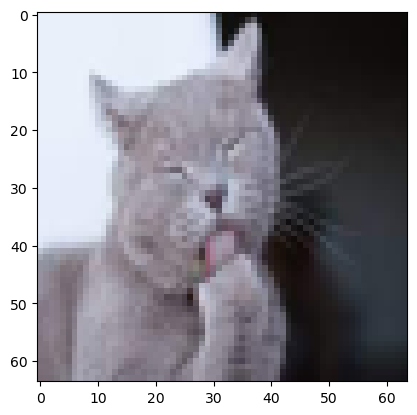

In [23]:
plt.imshow(cat_images[1])
cat_images.shape

We now flatten them and standardize them dividing them by 255 and create the labels (1 if it's a cat and 0 if it's not)

In [24]:
cat_test_X_flatten = cat_images.reshape(cat_images.shape[0],-1).T
cat_test_X = cat_test_X_flatten /255
m_cat_test = cat_test_X.shape[1]
cat_test_Y = np.ones((1, m_cat_test))

dog_test_X_flatten = dog_images.reshape(dog_images.shape[0],-1).T
dog_test_X = dog_test_X_flatten /255
m_dog_test = dog_test_X.shape[1]
dog_test_Y = np.zeros((1, m_dog_test))


In [25]:
test_X = np.concatenate((cat_test_X, dog_test_X), axis=1)
test_Y = np.concatenate((cat_test_Y, dog_test_Y), axis=1)

np.random.seed(1)
shuffle_indices = np.random.permutation(test_X.shape[1])
final_test_X = test_X[:, shuffle_indices]
final_test_Y = test_Y[:, shuffle_indices]

In [26]:
d = model(train_set_x, train_set_y, final_test_X, final_test_Y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 60.0 %


The Test accuracy dropped from the one of Exercise 8, probably due to the reduction of the initial resolution of the images and the noise of the dataset (e.g. a human in a dog image)

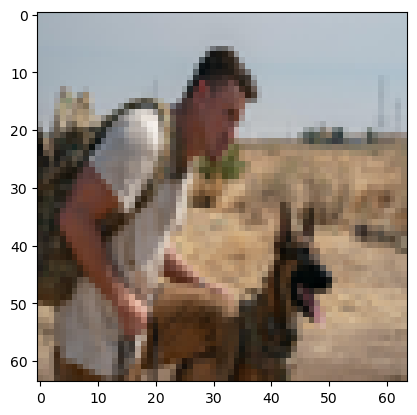

In [27]:
plt.imshow(dog_images[1])

#### Let's now play with the parameters num_iterations and learning_rate, and for that we will use a tuning dataset to select the best parameters and try to improve the accuracy in the test set.

In [28]:
tuning_cat_images = process_images("datasets/train/cats",image_range=(101,200))
tuning_dog_images = process_images("datasets/train/dogs",image_range=(101,200))

cat_tuning_X_flatten = tuning_cat_images.reshape(tuning_cat_images.shape[0],-1).T
cat_tuning_X = cat_tuning_X_flatten /255
m_cat_tuning = cat_tuning_X.shape[1]
cat_tuning_Y = np.ones((1, m_cat_tuning))

dog_tuning_X_flatten = tuning_dog_images.reshape(tuning_dog_images.shape[0],-1).T
dog_tuning_X = dog_tuning_X_flatten /255
m_dog_tuning = dog_tuning_X.shape[1]
dog_tuning_Y = np.zeros((1, m_dog_tuning))

cat_tuning_X.shape


(12288, 100)

In [29]:
tuning_X = np.concatenate((cat_tuning_X, dog_tuning_X), axis=1)
tuning_Y = np.concatenate((cat_tuning_Y, dog_tuning_Y), axis=1)

np.random.seed(1)
shuffle_indices = np.random.permutation(tuning_X.shape[1])
final_tuning_X = tuning_X[:, shuffle_indices]
final_tuning_Y = tuning_Y[:, shuffle_indices]

Let's tune from these values num_iterations = [1000, 2000, 4000] and learning_rate = [0.001, 0.005, 0.01, 0.05]

In [30]:
num_iterations_list = [1000, 2000, 4000]
learning_rate_list = [0.001, 0.005, 0.01, 0.05]

for num_iterations in num_iterations_list:
    for learning_rate in learning_rate_list:
        print(f"num_iterations: {num_iterations} and learning_rate: {learning_rate}") 
        d = model(train_set_x, train_set_y, final_tuning_X, final_tuning_Y, num_iterations, learning_rate)

num_iterations: 1000 and learning_rate: 0.001
train accuracy: 86.60287081339713 %
test accuracy: 53.0 %
num_iterations: 1000 and learning_rate: 0.005


train accuracy: 96.65071770334929 %
test accuracy: 52.5 %
num_iterations: 1000 and learning_rate: 0.01
train accuracy: 98.56459330143541 %
test accuracy: 55.5 %
num_iterations: 1000 and learning_rate: 0.05


C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: divide by zero encountered in log
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost
C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost


train accuracy: 100.0 %
test accuracy: 54.0 %
num_iterations: 2000 and learning_rate: 0.001
train accuracy: 91.38755980861244 %
test accuracy: 53.0 %
num_iterations: 2000 and learning_rate: 0.005
train accuracy: 99.04306220095694 %
test accuracy: 55.0 %
num_iterations: 2000 and learning_rate: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 59.0 %
num_iterations: 2000 and learning_rate: 0.05
train accuracy: 100.0 %
test accuracy: 54.5 %
num_iterations: 4000 and learning_rate: 0.001
train accuracy: 95.69377990430623 %
test accuracy: 53.5 %
num_iterations: 4000 and learning_rate: 0.005
train accuracy: 99.52153110047847 %
test accuracy: 58.0 %
num_iterations: 4000 and learning_rate: 0.01
train accuracy: 100.0 %
test accuracy: 58.5 %
num_iterations: 4000 and learning_rate: 0.05
train accuracy: 100.0 %
test accuracy: 55.5 %


It seems like num_iterations: 2000 and learning_rate: 0.01 got the best metrics in the tuning set although we reached better accuracy in the test set without tuning.

In [31]:
d = model(train_set_x, train_set_y, final_test_X, final_test_Y, num_iterations = 2000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944


Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
Cost after iteration 1500: 0.087453
Cost after iteration 1600: 0.083286
Cost after iteration 1700: 0.079487
Cost after iteration 1800: 0.076007
Cost after iteration 1900: 0.072809
train accuracy: 99.52153110047847 %
test accuracy: 59.5 %


#### Let's try a different initialization method

In [32]:
def initialize_with_random(dim):
    np.random.seed(1)
    w = np.random.randn(dim, 1)
    b = np.random.uniform(low=-1, high=1)

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [33]:
def random_model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###

    # initialize parameters with zeros (≈ 1 line of code)
    dim = X_train.shape[0]
    w, b = initialize_with_random(dim)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [34]:
d = random_model(train_set_x, train_set_y, final_test_X, final_test_Y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: nan


C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: divide by zero encountered in log
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost
C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost


Cost after iteration 100: nan
Cost after iteration 200: inf
Cost after iteration 300: inf
Cost after iteration 400: inf
Cost after iteration 500: inf
Cost after iteration 600: inf
Cost after iteration 700: inf
Cost after iteration 800: inf
Cost after iteration 900: inf


Cost after iteration 1000: inf
Cost after iteration 1100: inf
Cost after iteration 1200: 2.674285
Cost after iteration 1300: 2.499024
Cost after iteration 1400: 2.337276
Cost after iteration 1500: 2.186888
Cost after iteration 1600: 2.047963
Cost after iteration 1700: 1.920922
Cost after iteration 1800: 1.804976
Cost after iteration 1900: 1.699210
train accuracy: 77.99043062200957 %
test accuracy: 53.0 %


#### More training data
We were not able to increase the accuracy performance of the model by tuning the parameters learning_rate and num_iterations or by initializing the parameters randomly. Let's test our hypothesis that by feeding the model data from the same dataset we are testing from we will increase our accuracy in the test set.

In [35]:
final_X_train = np.concatenate((final_tuning_X, final_tuning_X), axis=1) 
final_Y_train = np.concatenate((final_tuning_Y, final_tuning_Y), axis=1)

np.random.seed(1)
shuffle_indices = np.random.permutation(final_X_train.shape[1])
final_X_train = final_X_train[:, shuffle_indices]
final_Y_train = final_Y_train[:, shuffle_indices]

In [36]:
d = model(final_X_train, final_Y_train, final_test_X, final_test_Y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.712673
Cost after iteration 200: 1.440646
Cost after iteration 300: 1.216221


Cost after iteration 400: 1.024674
Cost after iteration 500: 0.864122
Cost after iteration 600: 0.723605
Cost after iteration 700: 0.597213
Cost after iteration 800: 0.484856
Cost after iteration 900: 0.384619
Cost after iteration 1000: 0.291395
Cost after iteration 1100: 0.205838
Cost after iteration 1200: 0.161870
Cost after iteration 1300: 0.148282
Cost after iteration 1400: 0.140006
Cost after iteration 1500: 0.133060
Cost after iteration 1600: 0.126994
Cost after iteration 1700: 0.121589
Cost after iteration 1800: 0.116703
Cost after iteration 1900: 0.112240
train accuracy: 100.0 %
test accuracy: 57.0 %


#### Another preprocessing

We will divide each column (feature) by its standard deviation

In [39]:
train_set_x = train_set_x_flatten/np.std(train_set_x_flatten, axis=0, keepdims=True)
final_test_X = final_test_X * 255
final_test_X = (final_test_X)/np.std(final_test_X, axis=0, keepdims=True)

d = model(train_set_x, train_set_y, final_test_X, final_test_Y, num_iterations = 2000, learning_rate = 0.005)

C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: divide by zero encountered in log
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost
C:\Users\13042\AppData\Local\Temp\ipykernel_65832\3108564081.py:27: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m *np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))     # compute cost


train accuracy: 100.0 %
test accuracy: 56.5 %


After all that we weren't able to make our model better at predicting in our test set. There are still another alternatives that could help us like trying different activation functions, modify our training dataset to include more than 64 x 64 pixels or using different models like neural networks.